# Simple LSTM Model for Apple Stock Price Forecasting with Pickle Output

This notebook builds a streamlined LSTM model to forecast the Apple stock `Close` price using the preprocessed dataset from `preprocess_apple_stock_combined.ipynb`. It uses essential scaled features (`Close_Scaled`, `Close_Lag1_Scaled`, `Close_Lag2_Scaled`, `RSI_Scaled`, `MA7_Scaled`, `Day_of_Week_Scaled`) to minimize complexity. The model is evaluated with MSE, RMSE, MAE, and MAPE, visualized, and saved as a `.pickle` file along with the scaler for easy loading and prediction.

In [40]:
# Import required libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [41]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [42]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [43]:
# Step 1: Load preprocessed data
train = pd.read_csv('datasets/preprocessed_apple_stock_train.csv', parse_dates=['Date'], index_col='Date')
test = pd.read_csv('datasets/preprocessed_apple_stock_test.csv', parse_dates=['Date'], index_col='Date')
print('Training data shape:', train.shape)
print('Test data shape:', test.shape)


Training data shape: (8828, 34)
Test data shape: (2207, 34)


In [44]:
# Step 2: Create sequences for LSTM
def create_sequences(data, seq_length, features):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length]['Close_Scaled'])
    return np.array(X), np.array(y)


In [84]:
# Define essential features
features = [
    'Close_Scaled', 'Close_Lag1_Scaled', 'Close_Lag2_Scaled',  # Price history
    'RSI_Scaled', 'MA7_Scaled',                                # Technical indicators
    'Return_Scaled',                                           # Momentum/volatility
    'Volume_Scaled',                                           # Trading activity
    'Day_of_Week_Scaled'                                       # Seasonality
]
seq_length = 30

X_train, y_train = create_sequences(train, seq_length, features)
X_test, y_test = create_sequences(test, seq_length, features)
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

X_train shape: (8798, 30, 8) y_train shape: (8798,)
X_test shape: (2177, 30, 8) y_test shape: (2177,)


In [85]:
# Step 3: Build LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(150, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 100)           43600     
                                                                 
 dropout_4 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 150)               150600    
                                                                 
 dropout_5 (Dropout)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                7550      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 201801 (788.29 KB)
Trainable params: 201

In [86]:
# Step 4: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [99]:
# Step 5: Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
62/62 [==============================] - 7s 115ms/step - loss: 4.9065e-06 - val_loss: 6.3928e-05
Epoch 2/10
62/62 [==============================] - 6s 91ms/step - loss: 3.9460e-06 - val_loss: 1.1533e-04
Epoch 3/10
62/62 [==============================] - 7s 117ms/step - loss: 3.8736e-06 - val_loss: 9.7330e-05
Epoch 4/10
62/62 [==============================] - 8s 126ms/step - loss: 3.2791e-06 - val_loss: 1.9842e-04
Epoch 5/10
62/62 [==============================] - 9s 143ms/step - loss: 2.4510e-06 - val_loss: 1.3190e-04
Epoch 6/10
62/62 [==============================] - 8s 132ms/step - loss: 2.2102e-06 - val_loss: 1.3346e-04


In [100]:
# Step 6: Evaluate the model
y_pred = model.predict(X_test)


69/69 [==============================] - 1s 15ms/step


In [101]:
# Inverse scale predictions and actual values
with open('close_scaler.pkl', 'rb') as f:
    scaler_close = pickle.load(f)
y_test_unscaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = scaler_close.inverse_transform(y_pred)


In [102]:
# Calculate regression metrics
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mape = mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled)
print('Regression Metrics:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}%')


Regression Metrics:
MSE: 162.9543
RMSE: 12.7654
MAE: 9.1719
MAPE: 10.0045%


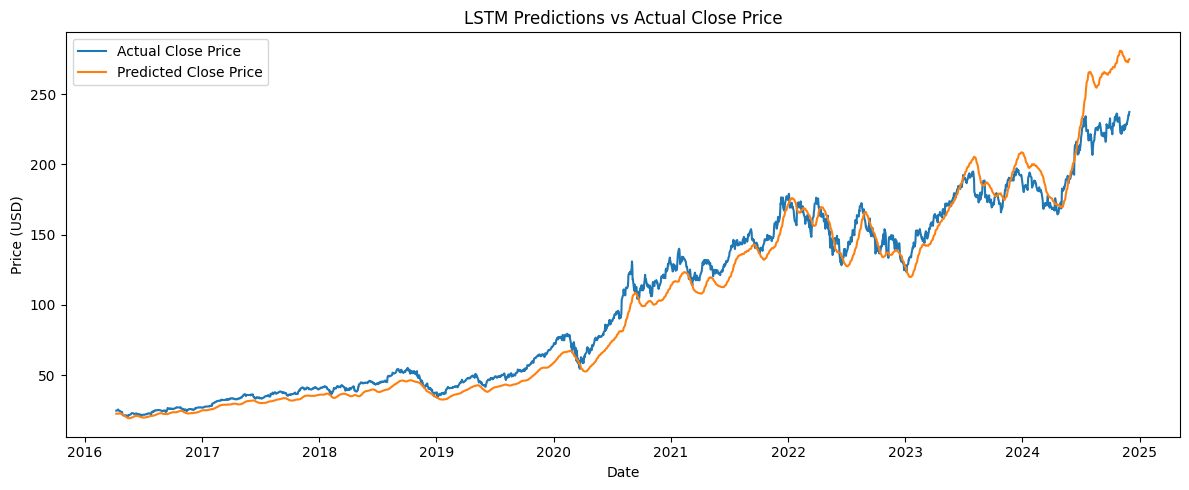

In [103]:
plt.figure(figsize=(12, 5))
plt.plot(test.index[seq_length:], y_test_unscaled, label='Actual Close Price')
plt.plot(test.index[seq_length:], y_pred_unscaled, label='Predicted Close Price')
plt.title('LSTM Predictions vs Actual Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

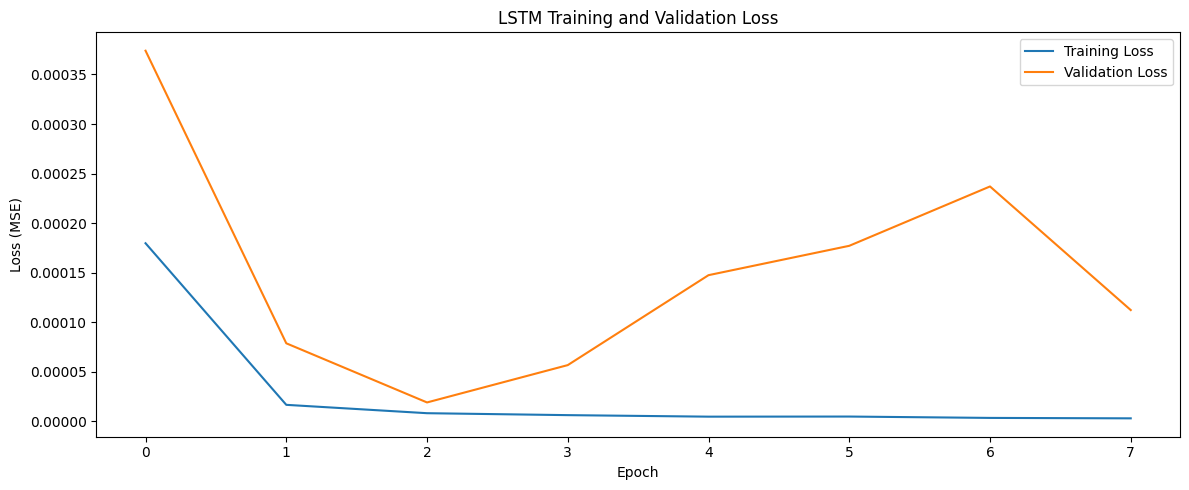

In [92]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()


In [93]:
# Step 8: Save the model as a pickle file
with open('apple_stock_lstm_model.pickle', 'wb') as f:
    pickle.dump(model, f)

predictions_df = pd.DataFrame({
    'Date': test.index[seq_length:],
    'Actual_Close': y_test_unscaled.flatten(),
    'Predicted_Close': y_pred_unscaled.flatten()
})
predictions_df.to_csv('lstm_predictions_simple.csv', index=False)
print('Model saved as: apple_stock_lstm_model.pickle')
print('Predictions saved as: lstm_predictions_simple.csv')


Model saved as: apple_stock_lstm_model.pickle
Predictions saved as: lstm_predictions_simple.csv


## Notes
- **Input**: Assumes `preprocessed_apple_stock_train.csv`, `preprocessed_apple_stock_test.csv`, and `scaler.pkl` are in the same directory.
- **Features**: Uses essential scaled features (`Close_Scaled`, `Close_Lag1_Scaled`, `Close_Lag2_Scaled`, `RSI_Scaled`, `MA7_Scaled`, `Day_of_Week_Scaled`) for price trends, momentum, and weekly seasonality.
- **Model**: Simple LSTM with 100 and 150 units, dropout (0.2), and dense layers for regression.
- **Training**: 10 epochs, batch size 128, 10% validation split, with early stopping (patience=5).
- **Metrics**: Evaluates with MSE (squared error), RMSE (error in USD), MAE (average absolute error), and MAPE (percentage error).
- **Output**: Saves the model as `apple_stock_lstm_model.pickle` and predictions as `lstm_predictions_simple.csv`.
- **Dependencies**: Install `pandas`, `numpy`, `scikit-learn`, `tensorflow`, `matplotlib`, `pickle` via `pip install pandas numpy scikit-learn tensorflow matplotlib`.
- **Usage**: Load the model with `pickle.load()` and use `scaler.pkl` for predictions.
- **Customization**: Adjust `seq_length` or add features like `MA20_Scaled` if needed.